<a href="https://colab.research.google.com/github/Pongpang-2102/Text_Mining_and_Sentiment_Analytics_KDAI_projects/blob/main/KDAI_Tutorial_TMSA_GRU_gensim_Sentiment_Analysis_101_(6_Aug_23).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pythainlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 90.9 MB/s eta 0:00:00


# Import Package ที่จำเป็น

In [ ]:
import pandas as pd
import re
#from nltk.tokenize import word_tokenize
from pythainlp.tokenize import word_tokenize
from keras.preprocessing.text import Tokenizer # check token ของประโยค

from keras.utils import pad_sequences # ความยาวของทุกๆประโยคเท่ากัน
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, LSTM, Bidirectional, Embedding, Dropout, BatchNormalization
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.optimizers import Adam

import seaborn as sn
import matplotlib.pyplot as plt

import pickle as p
import plotly
import plotly.graph_objs as go

from sklearn.metrics import confusion_matrix

from sklearn.metrics import classification_report

In [ ]:
from gensim.models import Word2Vec  # gensim

กำหนดจำนวน EPOCHS และ Batch Size ดังต่อไปนี้

In [ ]:
EPOCHS = 10
BS = 32

นิยาม Function สำหรับ Load Dataset ซึ่งประกอบด้วย ข้อความ (comments), ผลเฉลย (labels)

In [ ]:
comments = []
labels = []

# with open("train.txt",encoding="utf-8") as f:
with open("/content/drive/MyDrive/# KDAI_TextMining/Sentiment 060823/train.txt",encoding="utf-8") as f:
    for line in f:
        comments.append(line.strip())

#with open("train_label.txt",encoding="utf-8") as f:
with open("/content/drive/MyDrive/# KDAI_TextMining/Sentiment 060823/train_label.txt",encoding="utf-8") as f:
    for line in f:
        labels.append(line.strip())

In [ ]:
df = pd.DataFrame({ "category": labels, "comments": comments })
df.head()

,category,comments
0,neu,ประเทศเราผลิตและส่งออกยาสูบเยอะสุดในโลกจิงป่าวคับ
1,neu,คะ
2,neg,อิเหี้ยออมทำกูอยากกินเอ็มเค
3,neu,😅😅😅
4,neu,สวัสดีวันพุธ แนน อะไรนะ


ลบแถวที่ซ้ำลบแถวที่ซ้ำ

In [ ]:
df = df.drop_duplicates()

Sample ต้องมูล neu, pos และ neg อย่างละ 4300 แถว

In [ ]:
neu_df = df[df.category == "neu"].sample(4300)
neu_df.head()

,category,comments
1184,neu,เย้
11621,neu,25 ครูหยันสอน
11995,neu,ว่าจะออกยาริส แต่เพิ่มเงินอีกนิดได้ GT-R เลย ส...
17781,neu,เราเป็นเด็กอายุ 18 ที่ได้ร่วมเป็นสักขีพยานในเห...
10343,neu,ใช่แล้วววววว


In [ ]:
pos_df = df[df.category == "pos"]
pos_df.head()

,category,comments
10,pos,สนใจ ฟอจูนเนอร์ สีขาวครับ
16,pos,ไปดิ..รอไร
19,pos,อยากกินบาบีก้อนหรอ555555
22,pos,ต้องไปลองกันนะ
25,pos,ขอให้ SHEENe มีกิจการรุ่งเรือง ขายดีๆ ยอดไลท์เ...


In [ ]:
neg_df = df[df.category == "neg"].sample(4300)
neg_df.head()

,category,comments
16678,neg,ดีแม็กตีโจทย์แตก รถใช้งานออปชั่นน้อยราคาถูกภาษ...
3077,neg,บาร์บีก้อน ฮรุก พยาธิ;-;
6523,neg,เบื่อไก่อยากกินเอ็มเค
9663,neg,อิห่าราก กูแพ้แสงโสมเหรอวะ หมดไส้หมดพุง
21928,neg,ทำไมเล่น E-cig รอบนี้เหมือนปอดจะพัง ไอไม่หยุดเลย


รวม neg และ pos

In [ ]:
sentiment_df = pd.concat([neg_df, pos_df])
sentiment_df.head()

,category,comments
16678,neg,ดีแม็กตีโจทย์แตก รถใช้งานออปชั่นน้อยราคาถูกภาษ...
3077,neg,บาร์บีก้อน ฮรุก พยาธิ;-;
6523,neg,เบื่อไก่อยากกินเอ็มเค
9663,neg,อิห่าราก กูแพ้แสงโสมเหรอวะ หมดไส้หมดพุง
21928,neg,ทำไมเล่น E-cig รอบนี้เหมือนปอดจะพัง ไอไม่หยุดเลย


In [ ]:
comments = sentiment_df.comments.values # check ข้อความ
comments.shape

(8600,)

In [ ]:
comments[0]

'ดีแม็กตีโจทย์แตก รถใช้งานออปชั่นน้อยราคาถูกภาษีถูกไม่ต้องเอาม้าเอาทอร์คมาข่มก็ขายได้ ศูนย์ดีทนถึกอะไหล่ถูกเทียบแท้มีหมดเนี่ยแหละขายได้ ว่าออปชั่นน้อยอย่างน้อยหัวแคปตัวล่างยังมี abs ให้เลือก หารถใช้งานไปดูเรนเจอร์ตัวล่างไม่มี abs จบเห่เลย'

In [ ]:
category = sentiment_df.category.values # check label
category.shape

(8600,)

นิยาม Function เพื่อ Cleaning ประโยค โดยคัดไว้เฉพาะข้อความภาษาไทยตัดคำ แปลงเป็นตัวอักษรตัวเล็ก เก็บแต่ละคำของแต่ละประโยคไว้ใน List (temp) เพื่อหาความยาวของประโยค รวมทั้งเก็บแต่ละประโยคแบบ String (words) เพื่อสร้าง Train Data

In [ ]:
def cleaning(sentences):
  words = []
  temp = []
  for s in sentences:
    clean = re.sub(r'[^ก-๙]', "", s)
    w = word_tokenize(clean) # pythainlp
    temp.append([i.lower() for i in w])
    words.append(' '.join(w).lower())

  return words, temp

Clean ประโยคทั้งหมด

In [ ]:
cleaned_words, temp = cleaning(comments)
print(len(cleaned_words))
print(cleaned_words[:5])

8600
['ดี แม็ก ตี โจทย์ แตก รถ ใช้ งา นอ อป ชั่น น้อย ราคา ถูก ภาษี ถูก ไม่ต้อง เอา ม้า เอา ทอร์ค มา ข่ม ก็ ขาย ได้ ศูนย์ ดี ทน ถึก อะไหล่ ถูก เทียบ แท้ มี หมด เนี่ย แหละ ขาย ได้ ว่า ออ ปชั่น น้อย อย่าง น้อย หัว แคป ตัว ล่าง ยังมี ให้ เลือก หา รถ ใช้งาน ไปดู เรนเจอร์ ตัว ล่าง ไม่ มี จบเห่ เลย', 'บาร์ บี ก้อน ฮ รุก พยาธิ', 'เบื่อ ไก่ อยาก กิน เอ็ม เค', 'อิ ห่า ราก กู แพ้ แสงโสม เหรอ วะ หมดไส้หมดพุง', 'ทำไม เล่น รอบ นี้ เหมือน ปอด จะ พัง ไอ ไม่ หยุด เลย']


นิยาม Function create_tokenizer เพื่อสร้าง Keras TokenizerObject

In [ ]:
def create_tokenizer(words, filters = ''):
    token = Tokenizer(filters=filters)   # keras
    token.fit_on_texts(words)
    return token

สร้าง Keras Tokenizer Object ที่มีการ Train ด้วย Sentence ที่ถูก Cleaning แล้ว ซึ่งเราจะได้ Bag of Word และจำนวนคำศัพท์ของ Bag of Word จาก Keras Tokenizer ดังภาพด้านล่าง

In [ ]:
train_word_tokenizer = create_tokenizer(cleaned_words) # cleaned_words
vocab_size = len(train_word_tokenizer.word_index) + 1

train_word_tokenizer.word_index

{'ไม่': 1,
 'ไป': 2,
 'เลย': 3,
 'ที่': 4,
 'มา': 5,
 'ได้': 6,
 'ก็': 7,
 'กิน': 8,
 'มี': 9,
 'จะ': 10,
 'ๆ': 11,
 'แล้ว': 12,
 'แต่': 13,
 'มาก': 14,
 'ให้': 15,
 'ว่า': 16,
 'ครับ': 17,
 'ค่ะ': 18,
 'ของ': 19,
 'เป็น': 20,
 'มัน': 21,
 'นะ': 22,
 'นี้': 23,
 'ใช้': 24,
 'อยาก': 25,
 'กับ': 26,
 'ดี': 27,
 'คือ': 28,
 'ใน': 29,
 'และ': 30,
 'เรา': 31,
 'ต้อง': 32,
 'คน': 33,
 'ชอบ': 34,
 'ด้วย': 35,
 'รถ': 36,
 'กว่า': 37,
 'ยัง': 38,
 'กัน': 39,
 'อีก': 40,
 'นี่': 41,
 'ถ้า': 42,
 'ละ': 43,
 'เพราะ': 44,
 'เอา': 45,
 'แบบ': 46,
 'กู': 47,
 'ผม': 48,
 'กก': 49,
 'ซื้อ': 50,
 'อะไร': 51,
 'ทำ': 52,
 'อยู่': 53,
 'เบียร์': 54,
 'แม่': 55,
 'ง': 56,
 'อะ': 57,
 'ดู': 58,
 'แพง': 59,
 'สวย': 60,
 'บอก': 61,
 'ก้อน': 62,
 'พอ': 63,
 'เคย': 64,
 'เหมือน': 65,
 'อ่ะ': 66,
 'อร่อย': 67,
 'แค่': 68,
 'ช้าง': 69,
 'หมด': 70,
 'พี่': 71,
 'อย่าง': 72,
 'เห็น': 73,
 'ตัว': 74,
 'หน้า': 75,
 'จาก': 76,
 'มึง': 77,
 'แดก': 78,
 'ลอง': 79,
 'บุหรี่': 80,
 'ราคา': 81,
 'วัน': 82,
 'ผ้าอนามัย': 83,

นิยาม Function เพื่อหาความยาวสูงสุดของคำในประโยค ซึ่งเราจะค้นหาประโยคที่มีความยาวสูงสูดโดยใช้  Parameter key = len และนับคำในประโยคโดยใช้ Function len

In [ ]:
def max_length(words):
    return(len(max(words, key = len))) # เช็คความยาวของประโยคที่ยาวที่สุด

กำหนดความยาวสูงสุดของคำในประโยคให้กับ max_length เพื่อเตรียมทำ Padding และกำหนดจำนวน Step ของ GRU Network ซึ่งพบว่าประโยคยาวที่สุดมีความยาว 361 คำ

In [ ]:
max_length = max_length(temp)
max_length

360

นิยาม Function เพื่อแปลงคำเป็นตัวเลข

In [ ]:
def encoding_doc(token, words):
    return(token.texts_to_sequences(words))

แปลงคำในประโยคที่ได้ทำ Cleaning เป็นตัวเลข ด้วย Keras Tokenizer Object ที่ถูก Train แล้ว

In [ ]:
encoded_doc = encoding_doc(train_word_tokenizer, cleaned_words)

print(cleaned_words[0])
print(encoded_doc[0])

ดี แม็ก ตี โจทย์ แตก รถ ใช้ งา นอ อป ชั่น น้อย ราคา ถูก ภาษี ถูก ไม่ต้อง เอา ม้า เอา ทอร์ค มา ข่ม ก็ ขาย ได้ ศูนย์ ดี ทน ถึก อะไหล่ ถูก เทียบ แท้ มี หมด เนี่ย แหละ ขาย ได้ ว่า ออ ปชั่น น้อย อย่าง น้อย หัว แคป ตัว ล่าง ยังมี ให้ เลือก หา รถ ใช้งาน ไปดู เรนเจอร์ ตัว ล่าง ไม่ มี จบเห่ เลย
[27, 1422, 853, 1189, 556, 36, 24, 5732, 826, 2147, 542, 217, 81, 157, 473, 157, 238, 45, 1258, 45, 5733, 5, 3506, 7, 91, 6, 323, 27, 334, 3507, 675, 157, 641, 1045, 9, 70, 277, 557, 91, 6, 16, 134, 3013, 217, 72, 217, 366, 1338, 74, 558, 777, 15, 230, 225, 36, 957, 515, 2654, 74, 558, 1, 9, 4239, 3]


นิยาม Function เพื่อทำ Padding ตัวเลขที่แทนแต่ละคำในประโยค โดยกำหนดให้มีการเติม 0 เพื่อให้แต่ละประโยคมีความยาวเท่ากัน (361 คำ)

In [ ]:
def padding_doc(encoded_doc, max_length):
    return(pad_sequences(encoded_doc, maxlen = max_length, padding = "post"))

ทำ Padding

In [ ]:
padded_doc = padding_doc(encoded_doc, max_length) # ทำให้ ความยาวเท่ากันก่อน Input เข้า Model
print("Shape of padded docs = ",padded_doc.shape)

print(cleaned_words[2])
print(encoded_doc[2])
print(padded_doc[2])

Shape of padded docs =  (8600, 360)
เบื่อ ไก่ อยาก กิน เอ็ม เค
[288, 1089, 25, 8, 159, 107]
[ 288 1089   25    8  159  107    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0 

In [ ]:
unique_category = list(set(category))
unique_category

['pos', 'neg']

สร้าง output_tokenizer ด้วยการ Train tokenizer ด้วยชื่อ Class ทั้งหมด 2 Class

In [ ]:
output_tokenizer = create_tokenizer(unique_category)
output_tokenizer

แปลงผลเฉลยเป็นตัวเลขโดยใช้ output_tokenizer

In [ ]:
encoded_output = encoding_doc(output_tokenizer, category) # เปลี่ยน label จากตัวอักษร neg  ให้เป็น ตัวเลข 2
print(category[0:2])
print(encoded_output[0:2])
#  neg:2 อีกอัน pos:1

['neg' 'neg']
[[2], [2]]


เพิ่มมิติของผลเฉลยจาก 8600 เป็น 8600 x 1 สำหรับการเข้ารหัสผลเฉลยแบบ One Hot

In [ ]:
encoded_output = np.array(encoded_output).reshape(len(encoded_output), 1)
encoded_output.shape

(8600, 1)

นิยาม Function การเข้ารหัสผลเฉลยแบบ One Hot

In [ ]:
def one_hot(encode):
  oh = OneHotEncoder(sparse = False) # ทำ One hot encoding กับ Label
  return(oh.fit_transform(encode))

เข้ารหัสผลเฉลยแบบ One Hot

In [ ]:
output_one_hot = one_hot(encoded_output)
print(encoded_output[0])
print(output_one_hot[0])

[2]
[0. 1.]


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


# Gensim

In [ ]:
from gensim.models import Word2Vec # gensim

In [ ]:
from gensim.models import KeyedVectors

In [ ]:
dimension = 128

In [ ]:
sentences = [st.split() for st in cleaned_words]

In [ ]:
# ถ้าจะสร้าง Word2Vec ใหม่ให้เปิดตรงนี้
w2v_model = Word2Vec(sentences, min_count=1, vector_size=dimension, workers=6, sg=1, epochs=1000)

In [ ]:
#ถ้าจะสร้าง Word2Vec ใหม่ให้เปิดตรงนี้
w2v_model.save('w2v_model_GRU_gensim.bin')

In [ ]:
new_model = Word2Vec.load('w2v_model_GRU_gensim.bin')

In [ ]:
train_word_tokenizer.word_index.items()

dict_items([('ไม่', 1), ('ไป', 2), ('เลย', 3), ('ที่', 4), ('มา', 5), ('ได้', 6), ('ก็', 7), ('กิน', 8), ('มี', 9), ('จะ', 10), ('ๆ', 11), ('แล้ว', 12), ('แต่', 13), ('มาก', 14), ('ให้', 15), ('ว่า', 16), ('ครับ', 17), ('ค่ะ', 18), ('ของ', 19), ('เป็น', 20), ('มัน', 21), ('นะ', 22), ('นี้', 23), ('ใช้', 24), ('อยาก', 25), ('กับ', 26), ('ดี', 27), ('คือ', 28), ('ใน', 29), ('และ', 30), ('เรา', 31), ('ต้อง', 32), ('คน', 33), ('ชอบ', 34), ('ด้วย', 35), ('รถ', 36), ('กว่า', 37), ('ยัง', 38), ('กัน', 39), ('อีก', 40), ('นี่', 41), ('ถ้า', 42), ('ละ', 43), ('เพราะ', 44), ('เอา', 45), ('แบบ', 46), ('กู', 47), ('ผม', 48), ('กก', 49), ('ซื้อ', 50), ('อะไร', 51), ('ทำ', 52), ('อยู่', 53), ('เบียร์', 54), ('แม่', 55), ('ง', 56), ('อะ', 57), ('ดู', 58), ('แพง', 59), ('สวย', 60), ('บอก', 61), ('ก้อน', 62), ('พอ', 63), ('เคย', 64), ('เหมือน', 65), ('อ่ะ', 66), ('อร่อย', 67), ('แค่', 68), ('ช้าง', 69), ('หมด', 70), ('พี่', 71), ('อย่าง', 72), ('เห็น', 73), ('ตัว', 74), ('หน้า', 75), ('จาก', 76), ('มึง

In [ ]:
train_word_tokenizer

In [ ]:
train_word_tokenizer.word_index

{'ไม่': 1,
 'ไป': 2,
 'เลย': 3,
 'ที่': 4,
 'มา': 5,
 'ได้': 6,
 'ก็': 7,
 'กิน': 8,
 'มี': 9,
 'จะ': 10,
 'ๆ': 11,
 'แล้ว': 12,
 'แต่': 13,
 'มาก': 14,
 'ให้': 15,
 'ว่า': 16,
 'ครับ': 17,
 'ค่ะ': 18,
 'ของ': 19,
 'เป็น': 20,
 'มัน': 21,
 'นะ': 22,
 'นี้': 23,
 'ใช้': 24,
 'อยาก': 25,
 'กับ': 26,
 'ดี': 27,
 'คือ': 28,
 'ใน': 29,
 'และ': 30,
 'เรา': 31,
 'ต้อง': 32,
 'คน': 33,
 'ชอบ': 34,
 'ด้วย': 35,
 'รถ': 36,
 'กว่า': 37,
 'ยัง': 38,
 'กัน': 39,
 'อีก': 40,
 'นี่': 41,
 'ถ้า': 42,
 'ละ': 43,
 'เพราะ': 44,
 'เอา': 45,
 'แบบ': 46,
 'กู': 47,
 'ผม': 48,
 'กก': 49,
 'ซื้อ': 50,
 'อะไร': 51,
 'ทำ': 52,
 'อยู่': 53,
 'เบียร์': 54,
 'แม่': 55,
 'ง': 56,
 'อะ': 57,
 'ดู': 58,
 'แพง': 59,
 'สวย': 60,
 'บอก': 61,
 'ก้อน': 62,
 'พอ': 63,
 'เคย': 64,
 'เหมือน': 65,
 'อ่ะ': 66,
 'อร่อย': 67,
 'แค่': 68,
 'ช้าง': 69,
 'หมด': 70,
 'พี่': 71,
 'อย่าง': 72,
 'เห็น': 73,
 'ตัว': 74,
 'หน้า': 75,
 'จาก': 76,
 'มึง': 77,
 'แดก': 78,
 'ลอง': 79,
 'บุหรี่': 80,
 'ราคา': 81,
 'วัน': 82,
 'ผ้าอนามัย': 83,

In [ ]:
embedding_matrix = np.zeros((vocab_size, dimension))

for word, i in train_word_tokenizer.word_index.items():
    if word in new_model.wv.index_to_key:
        embedding_vector = new_model.wv[word]
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_vector

array([-0.4750515 ,  0.57788944,  0.15538147,  0.37973058,  1.070891  ,
       -0.3295801 , -0.12078518, -0.4806073 ,  0.72560215,  0.73302287,
       -0.31801343, -0.19465005,  0.40224534, -0.16898963,  0.08044869,
        0.21942396, -0.38393456, -0.11407218, -0.9436039 ,  0.46896526,
        0.44853997,  0.3462205 , -0.18335725,  0.02716409, -0.31525797,
        0.5540316 , -0.454636  ,  0.18632707, -0.24551618, -0.64752483,
       -0.3731354 ,  0.44793665,  0.06090567, -0.35060674, -0.46220973,
       -0.4931379 ,  0.5579325 , -0.6656336 ,  1.2356802 , -0.18773623,
       -0.29143494,  0.29310644,  0.33216414, -0.01510048, -0.50414526,
       -0.99669105,  0.29133892,  0.38344324, -0.07127251,  0.5474387 ,
        0.18659933, -0.17124501,  0.567995  ,  0.684349  , -0.5477787 ,
       -0.7854816 , -0.17370264,  0.27676886,  0.27725637, -0.71504235,
       -0.41786042,  0.44825888,  0.6804367 , -0.5266712 ,  1.279955  ,
        1.1772717 , -0.4986864 , -0.05191177, -0.66740435, -0.71

In [ ]:
embedding_vector[0]

-0.4750515

In [ ]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.07895157, -0.0730048 ,  0.22992577, ...,  0.12616485,
        -0.05281906,  0.20209745],
       [ 0.16696443, -0.02803243,  0.32839939, ..., -0.11336804,
        -0.25362211, -0.04109122],
       ...,
       [ 0.51679593,  0.16595006,  0.50631207, ...,  0.50984603,
        -0.71504533,  0.33726743],
       [ 0.74886286,  0.13565809, -0.28020963, ..., -0.22178216,
         0.02803504,  0.25776091],
       [-0.47505149,  0.57788944,  0.15538147, ...,  0.90050107,
        -0.43527234,  1.29360843]])

In [ ]:
embedding_matrix[2]

array([ 0.16696443, -0.02803243,  0.32839939,  0.06028769, -0.07160427,
        0.00911453,  0.07038653, -0.00858678, -0.11996622, -0.16272353,
        0.11588721, -0.10671774, -0.10112796,  0.00122463, -0.05002563,
       -0.24614057, -0.05859506,  0.2550126 ,  0.08985242,  0.05705341,
        0.22771813,  0.17511554,  0.42175847, -0.173794  ,  0.09339737,
        0.02461251,  0.07664276,  0.11648271,  0.23779853,  0.10414906,
       -0.00171933,  0.05001573, -0.01718587,  0.07241175, -0.29415774,
       -0.0975166 , -0.00717905, -0.101721  ,  0.04465988, -0.01992004,
        0.07479262,  0.01688393,  0.26631546, -0.22685564,  0.10973446,
        0.1593457 ,  0.03580642, -0.12775093, -0.18962795, -0.12710808,
        0.1560622 , -0.11413407, -0.13013178,  0.48736694,  0.03584177,
       -0.12950437,  0.21557143,  0.10908646, -0.20641571, -0.19546613,
       -0.13864334,  0.03331199,  0.16415299, -0.13728973,  0.05878889,
       -0.10538866,  0.3182101 ,  0.11566191,  0.12981102, -0.05

แบ่ง Input Data พร้อมผลเฉลย (Dataset) สำหรับ Train 80% และ Validate 20% โดยใช้ Parameter แบบ Stratified Sampling เพื่อให้มั่นใจว่าจะได้ Validate Dataset ที่มีข้อมูลครบทุก Intent

In [ ]:
train_X, val_X, train_Y, val_Y = train_test_split(padded_doc, output_one_hot, shuffle = True, test_size = 0.2, stratify=output_one_hot)

Print Shape ของ Dataset

In [ ]:
print("Shape of train_X = %s and train_Y = %s" % (train_X.shape, train_Y.shape))
print("Shape of val_X = %s and val_Y = %s" % (val_X.shape, val_Y.shape))

Shape of train_X = (6880, 360) and train_Y = (6880, 2)
Shape of val_X = (1720, 360) and val_Y = (1720, 2)


กำหนดจำนวน Intent ให้กับ num_classes สำหรับนิยามจำนวน Output Node ของ GRU Neural Network

In [ ]:
num_classes = len(unique_category)
num_classes

2

นิยาม Model แบบ GRU
นิยาม Model แบบ GRU ซึ่งเป็น Recurrent Neural Network (RNN) แบบหนึ่ง โดยกำหนดค่า learning rate (lr) ให้เป็น 0.0001  (ใน colab ให้ใช้ learning_rate แทน lr)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, LSTM, Bidirectional, Embedding, Dropout, BatchNormalization
from tensorflow.keras.models import load_model

from tensorflow.keras.optimizers import Adam
adam = Adam(learning_rate=0.0001)

def create_model(vocab_size, max_length):
  model = Sequential()

  model.add(Embedding(vocab_size, dimension, input_length = max_length,  trainable = False, weights=[embedding_matrix]))
# จุดที่ต่างจาก Model ที่ไม่ได้ใช้ Gensim --- > trainable = False, weights=[embedding_matrix]


  #model.add(Bidirectional(LSTM(128),merge_mode="concat"))
  model.add(Bidirectional(GRU(128, activation = "relu"))) # activation = "relu"
  model.add(Dense(128, activation = "relu"))
  model.add(Dropout(0.5))  # แก้ปัญหา Overfitting
  model.add(Dense(64, activation = "relu"))
  model.add(Dropout(0.5))  # แก้ปัญหา Overfitting
  model.add(BatchNormalization()) # แก้ปัญหา Overfitting
  model.add(Dense(num_classes, activation = "softmax"))

  return model

model = create_model(vocab_size, max_length)

Compile และ Print ชนิดของ Layer, Output Shape และจำนวน Parameter ของ Model

In [ ]:
model.compile(loss = "categorical_crossentropy", optimizer = adam, metrics = ["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 360, 128)          1331456   
                                                                 
 bidirectional (Bidirection  (None, 256)               198144    
 al)                                                             
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                        

สร้างจุด Check Point เพื่อ Save Model เฉพาะ Epoch ที่มี val_loss น้อยที่สุด

In [ ]:
filename = 'model_GRU_gensim.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

Train Model

In [ ]:
hist = model.fit(train_X, train_Y, epochs = EPOCHS, batch_size = BS, validation_data = (val_X, val_Y), callbacks = [checkpoint])

Epoch 1/10
215/215 [==============================] - ETA: 0s - loss: 0.9820 - accuracy: 0.5199
Epoch 1: val_loss improved from inf to 0.66187, saving model to model_GRU_gensim.h5
215/215 [==============================] - 126s 537ms/step - loss: 0.9820 - accuracy: 0.5199 - val_loss: 0.6619 - val_accuracy: 0.6105
Epoch 2/10


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


215/215 [==============================] - ETA: 0s - loss: 0.8632 - accuracy: 0.5605
Epoch 2: val_loss improved from 0.66187 to 0.61461, saving model to model_GRU_gensim.h5
215/215 [==============================] - 121s 561ms/step - loss: 0.8632 - accuracy: 0.5605 - val_loss: 0.6146 - val_accuracy: 0.6860
Epoch 3/10
215/215 [==============================] - ETA: 0s - loss: 0.7805 - accuracy: 0.6039
Epoch 3: val_loss improved from 0.61461 to 0.58033, saving model to model_GRU_gensim.h5
215/215 [==============================] - 121s 562ms/step - loss: 0.7805 - accuracy: 0.6039 - val_loss: 0.5803 - val_accuracy: 0.7006
Epoch 4/10
215/215 [==============================] - ETA: 0s - loss: 0.7212 - accuracy: 0.6376
Epoch 4: val_loss improved from 0.58033 to 0.56275, saving model to model_GRU_gensim.h5
215/215 [==============================] - 120s 560ms/step - loss: 0.7212 - accuracy: 0.6376 - val_loss: 0.5627 - val_accuracy: 0.7047
Epoch 5/10
215/215 [==============================] - 

Save History

In [ ]:
with open('history_model_GRU_gensim', 'wb') as file:
    p.dump(hist.history, file)

Load History

In [ ]:
with open('history_model_GRU_gensim', 'rb') as file:
    his = p.load(file)

Plot Loss และ Validate Loss

In [ ]:
h1 = go.Scatter(y=his['loss'],
                    mode="lines", line=dict(
                    width=2,
                    color='blue'),
                    name="loss"
                   )
h2 = go.Scatter(y=his['val_loss'],
                    mode="lines", line=dict(
                    width=2,
                    color='red'),
                    name="val_loss"
                   )

data = [h1,h2]
layout1 = go.Layout(title='Loss',
                   xaxis=dict(title='epochs'),
                   yaxis=dict(title=''))
fig1 = go.Figure(data = data, layout=layout1)
fig1.show()

Plot Accuracy และ Validate Accuracy

In [ ]:
h1 = go.Scatter(y=his['accuracy'],
                    mode="lines", line=dict(
                    width=2,
                    color='blue'),
                    name="acc"
                   )
h2 = go.Scatter(y=his['val_accuracy'],
                    mode="lines", line=dict(
                    width=2,
                    color='red'),
                    name="val_acc"
                   )

data = [h1,h2]
layout1 = go.Layout(title='Accuracy',
                   xaxis=dict(title='epochs'),
                   yaxis=dict(title=''))
fig1 = go.Figure(data = data, layout=layout1)
fig1.show()

Load และ Print ชนิดของ Layer, Output Shape และจำนวน Parameter ของ Model

In [ ]:
predict_model = load_model(filename)
predict_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 360, 128)          1331456   
                                                                 
 bidirectional (Bidirection  (None, 256)               198144    
 al)                                                             
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                        

Evaluate Model

In [ ]:
score = predict_model.evaluate(val_X, val_Y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.4932686388492584
Test accuracy: 0.7581395506858826


Predict ด้วย Validate Dataset

In [ ]:
predicted_classes = np.argmax(predict_model.predict(val_X), axis=-1)
predicted_classes.shape  # ข้อมูลที่เราแบ่งไว้ 20 %

54/54 [==============================] - 6s 106ms/step


(1720,)

เปลี่ยน y_true จาก One Hot กลับเป็นเลขจำนวนเต็มฐานสิบ

In [ ]:
# เปลี่ยนจาก one-hot คืนค่ากลับ เป็น 0 หรือ 1

In [ ]:
y_true = np.argmax(val_Y,axis = 1)
print(val_Y[0])
print(y_true[0])

[0. 1.]
1


Save Confusion Matrix

In [ ]:
cm = confusion_matrix(y_true, predicted_classes)
np.savetxt("confusion_matrix_GRU_gensim.csv", cm, delimiter=",")

Plot Confusion Matrix

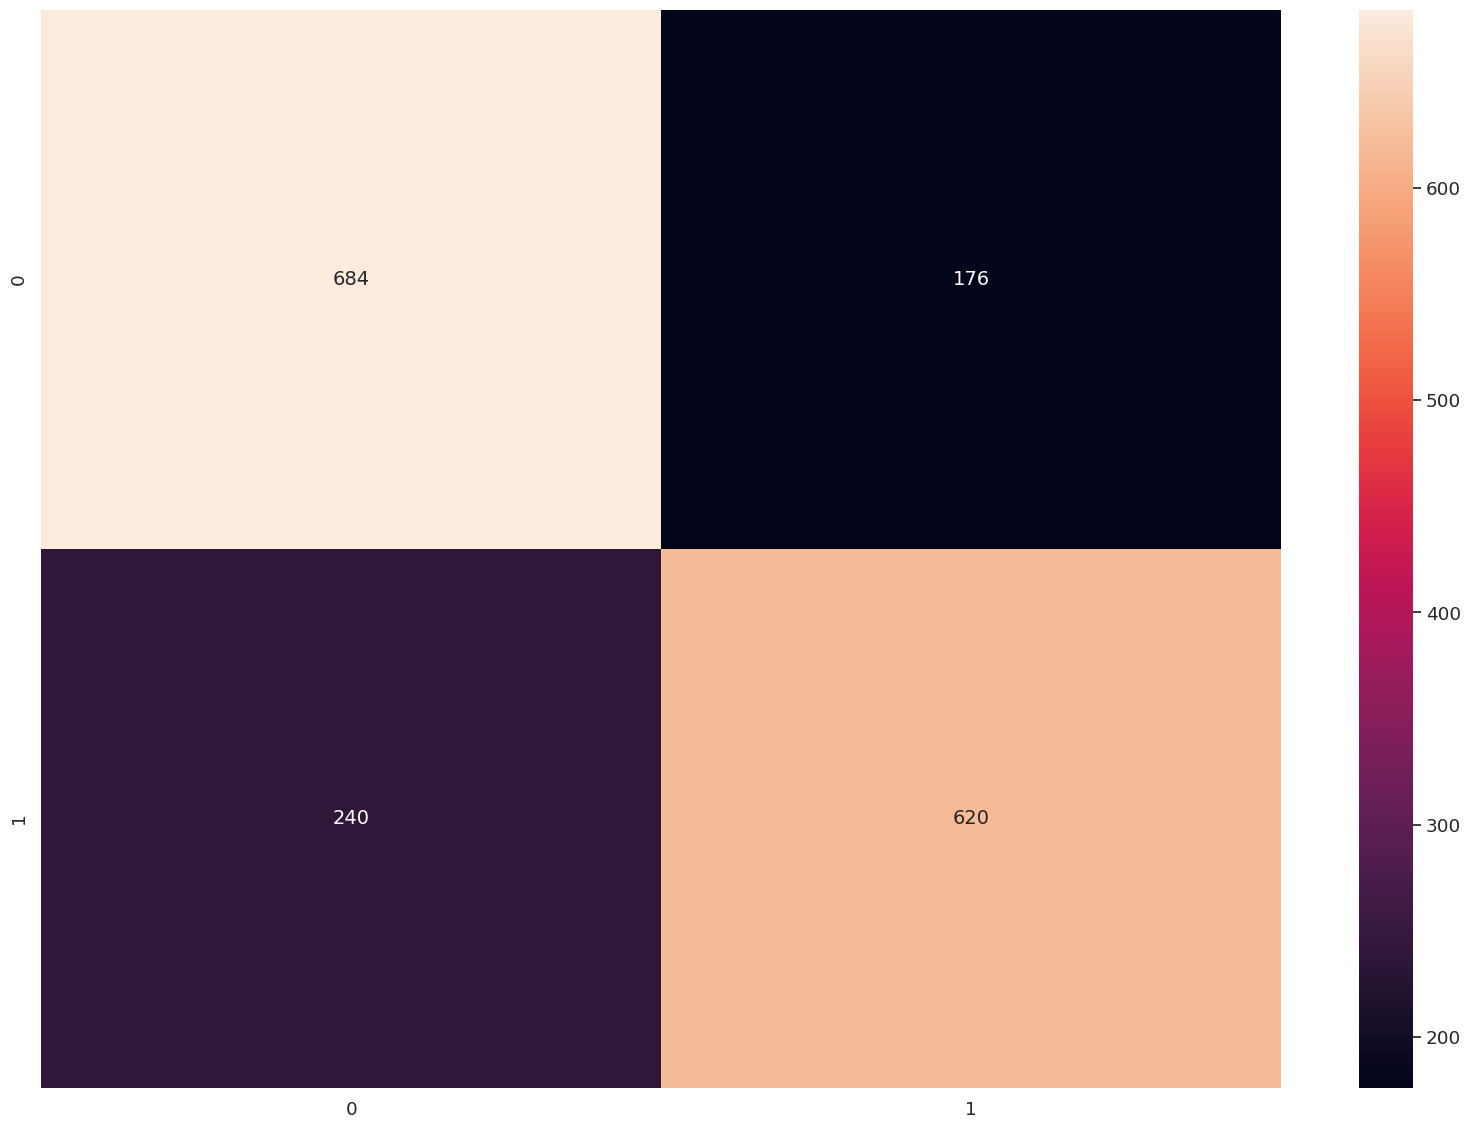

In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(cm, range(2), range(2))
plt.figure(figsize=(20,14))
sn.set(font_scale=1.2) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 14}, fmt='g') # for num predict size

plt.show()

ดึง Intent ทั้งหมดมาจาก output_tokenizer

In [ ]:
label_dict = output_tokenizer.word_index

ดึงชื่อของ Intent เก็บใน Label

In [ ]:
label = [key for key, value in label_dict.items()]

แสดง Precision, Recall, F1-score

In [ ]:
print(classification_report(y_true, predicted_classes, target_names=label, digits=4))

              precision    recall  f1-score   support

         pos     0.7403    0.7953    0.7668       860
         neg     0.7789    0.7209    0.7488       860

    accuracy                         0.7581      1720
   macro avg     0.7596    0.7581    0.7578      1720
weighted avg     0.7596    0.7581    0.7578      1720



ทดลองเปลี่ยน Model แบบ GRU เป็น LSTM
เราสามารถเปลี่ยนไปใช้ Model แบบ LSTM ได้ โดยปรับเปลี่ยนที่การนิยาม Model โดยเปลี่ยนจาก Bidirectional(GRU(128, activation = "relu")) เป็น Bidirectional(LSTM(128),merge_mode="concat")

In [ ]:
# model.add(Bidirectional(LSTM(128),merge_mode="concat"))

สำหรับ  parameter ที่ชื่อว่า merge_mode ของ LSTM นั้นหมายถึง วิธีการนำ Vector มาต่อกัน ซึ่งนอกจากต่อแบบ concat แล้ว ยังมีการต่อแบบอื่น ๆ คือ sum, mul และ ave

ขอบคุณ Wisesight (Thailand) Co., Ltd. สำหรับ Dataset